## Correlation Analysis 
Calculates correlation values for exposure-mediator pairs prior to running mediation model. Correlations are calculated with unadjusted and adjusted (BMI, sex, age) Spearman's correlation. Correlations with signed log transformations are also verified to ensure the best possible fit for the model. 

In [1]:
# Load necessary packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pingouin as pg
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Load in dataset
dataset = pd.read_csv('mediation_model_dataset.csv')

### Raw correlations 

In [3]:
# Define exposure and mediator variables, and covariates for adjusted correlations 
spo2_metrics = ['avg_spo2_no_desat_NREM', 'hb_desat']
spindle_metrics = ["SP_DENS_all_C", 'SP_CHIRP_all_C', 'SP_R_PHASE_IF_all_C']
covariates = ['sex', 'age', 'bmi']

# Standardize the PID columns
dataset['PID'] =dataset['PID'].astype(str).str.strip().str.lower()

In [4]:
# Calculating UNADJUSTED Speearman's correlations 

# Define results dictionaries 
rho_matrix_nocov = {}
pval_matrix_nocov = {}

def plot_partial_spearman_no_cov(df, x, y, plot):
    """
    Calculates and plots unadjusted Spearman's correlations from a df 
    df = input dataframe with exposure/mediator data
    x = exposure variables 
    y = mediator variables 
    plot = "yes" generates plots, "no" does not 
    """

    # Drop NaN values 
    df = df[[x, y]].dropna()
    plot_df = df.copy()

    # Generate Spearman's correlation values 
    results = pg.corr(x=plot_df[x], y=plot_df[y], method='spearman')

   
    n = results['n'].values[0]

    # Store into global matrices
    if y not in rho_matrix_nocov:
        rho_matrix_nocov[y] = {}
        pval_matrix_nocov[y] = {}
    
    rho_matrix_nocov[y][x] = results['r'].values[0]
    pval_matrix_nocov[y][x] = results['p-val'].values[0]
    

    print(f"\n{x} vs {y}")
    print(f"WITH outliers:     ρ = {results['r'].values[0]:.5f}, p = {results['p-val'].values[0]:.2e}, n = {n}")
   
    # Plot correlations, only turns on if "plot" argument is yes 
    if plot == "yes":
        plt.figure(figsize=(6, 5))
        sns.regplot(data=plot_df, x=x, y=y, lowess=True,
                    scatter_kws={'alpha': 0.5, 'color': 'coral'},
                    line_kws={'color': 'purple'})
        plt.title(f"{x} vs {y} (Spearman)\nρ = {results['r'].values[0]:.2f}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.tight_layout()
        plt.show()


# Loop through pairings 
for x in spo2_metrics:
    for y in spindle_metrics:
        plot_partial_spearman_no_cov(dataset, x, y, plot="no")

# Convert results to dataframe 
rho_df_nocov = pd.DataFrame(rho_matrix_nocov)
pval_df_nocov = pd.DataFrame(pval_matrix_nocov)

# Print 
# Print table 
print(f"\n Rho values \n {rho_df_nocov}")
print(f"\n P values \n {pval_df_nocov}")


avg_spo2_no_desat_NREM vs SP_DENS_all_C
WITH outliers:     ρ = 0.06279, p = 4.72e-03, n = 2023

avg_spo2_no_desat_NREM vs SP_CHIRP_all_C
WITH outliers:     ρ = -0.09522, p = 1.79e-05, n = 2023

avg_spo2_no_desat_NREM vs SP_R_PHASE_IF_all_C
WITH outliers:     ρ = 0.06548, p = 3.21e-03, n = 2023

hb_desat vs SP_DENS_all_C
WITH outliers:     ρ = -0.17530, p = 2.00e-15, n = 2023

hb_desat vs SP_CHIRP_all_C
WITH outliers:     ρ = 0.07739, p = 4.94e-04, n = 2023

hb_desat vs SP_R_PHASE_IF_all_C
WITH outliers:     ρ = -0.13510, p = 1.06e-09, n = 2023

 Rho values 
                         SP_DENS_all_C  SP_CHIRP_all_C  SP_R_PHASE_IF_all_C
avg_spo2_no_desat_NREM       0.062793       -0.095220             0.065481
hb_desat                    -0.175302        0.077387            -0.135100

 P values 
                         SP_DENS_all_C  SP_CHIRP_all_C  SP_R_PHASE_IF_all_C
avg_spo2_no_desat_NREM   4.723099e-03        0.000018         3.213554e-03
hb_desat                 1.999034e-15        0

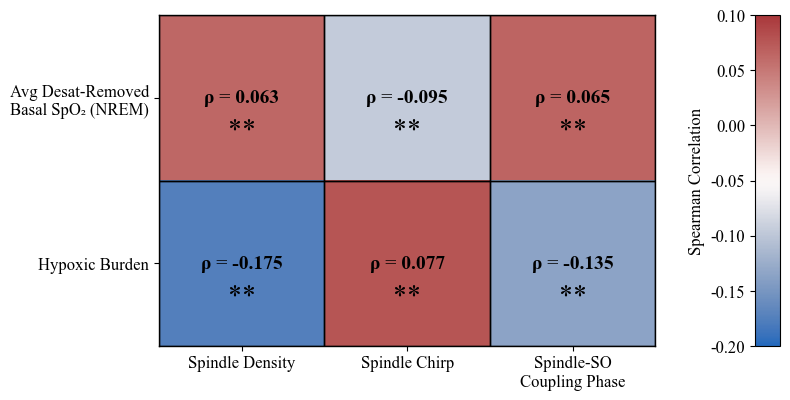

In [5]:
# Set font family 
plt.rcParams['font.family'] = 'Times New Roman'

# Generate figure 
fig, ax = plt.subplots(figsize=(8, 6))

# Normalize and set colormap
vmin, vmax = -0.2, 0.1
norm = plt.Normalize(vmin, vmax)
cmap = sns.color_palette("vlag", as_cmap=True)

# Show matrix as image
im = ax.imshow(rho_df_nocov.values, cmap=cmap, norm=norm)

# Custom axis labels
custom_x_labels = ['Spindle Density', 'Spindle Chirp', 'Spindle-SO\nCoupling Phase']
custom_y_labels = ['Avg Desat-Removed\nBasal SpO₂ (NREM)', 'Hypoxic Burden']

ax.set_xticks(np.arange(len(custom_x_labels)))
ax.set_yticks(np.arange(len(custom_y_labels)))
ax.set_xticklabels(custom_x_labels, fontsize=12)
ax.set_yticklabels(custom_y_labels, fontsize=12)

# Draw rectangle borders for each cell
for i in range(rho_df_nocov.shape[0]):
    for j in range(rho_df_nocov.shape[1]):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False,
                             edgecolor='black', linewidth=1)
        ax.add_patch(rect)

# Add significance markers
for i in range(rho_df_nocov.shape[0]):
    for j in range(rho_df_nocov.shape[1]):
        p = pval_df_nocov.iloc[i, j]
        rho = rho_df_nocov.iloc[i,j]
        if p < 0.01:
            ax.text(j, i+0.2, '**', ha='center', va='center', fontsize=20, color='black')
        elif p < 0.05:
            ax.text(j, i+0.2, '*', ha='center', va='center', fontsize=20, color='black')

# Print rho value in cell 
for i in range(rho_df_nocov.shape[0]):
    for j in range(rho_df_nocov.shape[1]):
        rho = rho_df_nocov.iloc[i, j]
        color = 'black' if rho < 0 else 'black'
        ax.text(j, i, f'ρ = {rho:.3f}', ha='center', va='center', fontsize=14, color=color, fontweight='bold')
        
# Thicken outer spines
for spine in ax.spines.values():
    spine.set_linewidth(1)

# Add colorbar with matched height
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Spearman Correlation", fontsize=12)
tick_vals = np.arange(-0.2, 0.15, 0.05) 
cbar.set_ticks(tick_vals)
cbar.ax.set_yticklabels([f"{0.00:.2f}" if abs(v) < 1e-10 else f"{v:.2f}" for v in tick_vals], fontsize=12)

# Position colorbar on the left
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

# Plot and show figure 
#plt.savefig("NAME FIGURE FILE.png", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [6]:
# Function to plot and compute Spearman's correlations.
rho_matrix = {}
pval_matrix = {}

def plot_partial_spearman(df, x, y, covariates, plot):
    """
    Calculates and plots covariate-adjusted Spearman's correlations from a df 
    df = input dataframe with exposure/mediator data
    x = exposure variables 
    y = mediator variables 
    covariates = covariate variables
    plot = "yes" generates plots, "no" does not 
    """
    df = df[[x, y] + covariates].dropna()
    plot_df = df.copy()

    # Generate Spearman's correlation values, covariate adjusted 
    results = pg.partial_corr(data=plot_df, x=x, y=y, covar=covariates, method='spearman')
    #r_wo = pg.partial_corr(data=df_wo, x=x, y=y, covar=covariates, method='spearman')
    n = results['n'].values[0]

    # Store into global matrices
    if y not in rho_matrix:
        rho_matrix[y] = {}
        pval_matrix[y] = {}
    rho_matrix[y][x] = results['r'].values[0]
    pval_matrix[y][x] = results['p-val'].values[0]
    
    # Print results for each exposure-mediator pairing 
    print(f"\n{x} vs {y} | adjusted for {covariates}")
    print(f"ρ = {results['r'].values[0]:.5f}, p = {results['p-val'].values[0]:.2e}, n = {n}")
   
    # Plot correlations, only turns on if "plot" argument is yes 
    if plot == "yes":
        # Residualize x and y with respect to covariates
        X_cov = sm.add_constant(plot_df[covariates])
        
        # Residuals for x
        model_x = sm.OLS(plot_df[x], X_cov).fit()
        x_resid = model_x.resid
    
        # Residuals for y
        model_y = sm.OLS(plot_df[y], X_cov).fit()
        y_resid = model_y.resid
    
        # Plot residuals
        plt.figure(figsize=(6, 5))
        sns.regplot(x=x_resid, y=y_resid, lowess=True,
                    scatter_kws={'alpha': 0.5, 'color': 'coral'},
                    line_kws={'color': 'purple'})
        plt.title(f"{x} vs {y} (adjusted)\nρ = {results['r'].values[0]:.2f}")
        plt.xlabel(f"{x} residuals")
        plt.ylabel(f"{y} residuals")
        plt.tight_layout()
        plt.show()


# Run this function through dataset 
for x in spo2_metrics:
    for y in spindle_metrics:
        plot_partial_spearman(dataset, x, y, covariates, plot="no")

# Convert results into dataframe 
rho_df_raw = pd.DataFrame(rho_matrix)
pval_df_raw = pd.DataFrame(pval_matrix)

# Print table 
print(f"\n Rho values \n {rho_df_raw}")
print(f"\n P values \n {pval_df_raw}")


avg_spo2_no_desat_NREM vs SP_DENS_all_C | adjusted for ['sex', 'age', 'bmi']
ρ = -0.05867, p = 8.35e-03, n = 2023

avg_spo2_no_desat_NREM vs SP_CHIRP_all_C | adjusted for ['sex', 'age', 'bmi']
ρ = -0.02519, p = 2.58e-01, n = 2023

avg_spo2_no_desat_NREM vs SP_R_PHASE_IF_all_C | adjusted for ['sex', 'age', 'bmi']
ρ = -0.02581, p = 2.46e-01, n = 2023

hb_desat vs SP_DENS_all_C | adjusted for ['sex', 'age', 'bmi']
ρ = -0.06357, p = 4.26e-03, n = 2023

hb_desat vs SP_CHIRP_all_C | adjusted for ['sex', 'age', 'bmi']
ρ = -0.00447, p = 8.41e-01, n = 2023

hb_desat vs SP_R_PHASE_IF_all_C | adjusted for ['sex', 'age', 'bmi']
ρ = -0.04944, p = 2.63e-02, n = 2023

 Rho values 
                         SP_DENS_all_C  SP_CHIRP_all_C  SP_R_PHASE_IF_all_C
avg_spo2_no_desat_NREM      -0.058673       -0.025192            -0.025808
hb_desat                    -0.063573       -0.004471            -0.049443

 P values 
                         SP_DENS_all_C  SP_CHIRP_all_C  SP_R_PHASE_IF_all_C
avg_spo2_n

### Generating heatmap figure (raw data)

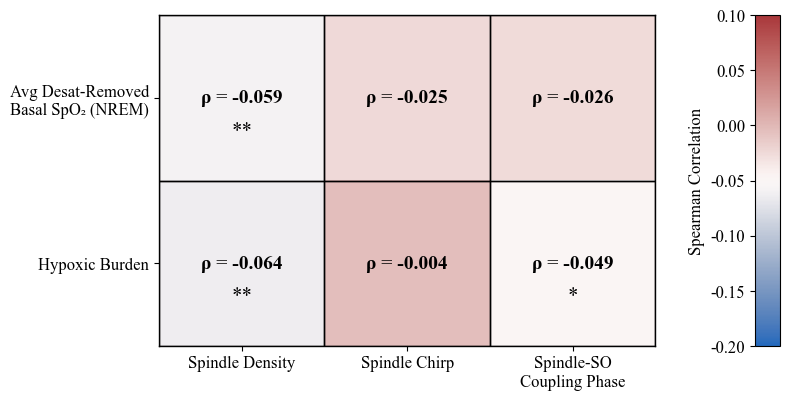

In [7]:
# Covariate-adjusted Spearman's correlation heat map for raw exposure-mediator data 

# Set font family 
plt.rcParams['font.family'] = 'Times New Roman' 

# Generate figure plot 
fig, ax = plt.subplots(figsize=(8, 6))

# Normalize and colormap based on rho values 
vmin, vmax = -0.2, 0.1
norm = plt.Normalize(vmin, vmax)
cmap = sns.color_palette("vlag", as_cmap=True)

# Show matrix as image
im = ax.imshow(rho_df_raw.values, cmap=cmap, norm=norm)

# Custom axis labels
custom_x_labels = ['Spindle Density', 'Spindle Chirp', 'Spindle-SO\nCoupling Phase']
custom_y_labels = ['Avg Desat-Removed\nBasal SpO₂ (NREM)', 'Hypoxic Burden']

ax.set_xticks(np.arange(len(custom_x_labels)))
ax.set_yticks(np.arange(len(custom_y_labels)))
ax.set_xticklabels(custom_x_labels, fontsize=12)
ax.set_yticklabels(custom_y_labels, fontsize=12)

# Draw rectangle borders for each cell
for i in range(rho_df_raw.shape[0]):
    for j in range(rho_df_raw.shape[1]):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False,
                             edgecolor='black', linewidth=1)
        ax.add_patch(rect)

# Print rho values in each cell 
for i in range(rho_df_raw.shape[0]):
    for j in range(rho_df_raw.shape[1]):
        rho = rho_df_raw.iloc[i, j]
        ax.text(j, i, f'ρ = {rho:.3f}', ha='center', va='center', fontsize=14, color='black', fontweight='bold')

# Annotate with asterisks for p-values 
for i in range(rho_df_raw.shape[0]):
    for j in range(rho_df_raw.shape[1]):
        p = pval_df_raw.iloc[i, j]
        if p < 0.01:
            ax.text(j, i+0.2, '**', ha='center', va='center', fontsize=15, color='black')
        elif p < 0.05:
            ax.text(j, i+0.2, '*', ha='center', va='center', fontsize=15, color='black')

# Thicken outer spines for clarity 
for spine in ax.spines.values():
    spine.set_linewidth(1)

# Add colorbar with matched height 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Spearman Correlation", fontsize=12)
tick_vals = np.arange(-0.2, 0.15, 0.05) 
cbar.set_ticks(tick_vals)
cbar.ax.set_yticklabels([f"{0.00:.2f}" if abs(v) < 1e-10 else f"{v:.2f}" for v in tick_vals], fontsize=12) #Manually define for 0 due to rounding issues
cbar.ax.yaxis.set_ticks_position('left')   
cbar.ax.yaxis.set_label_position('left')   

# Save and show figure 

#plt.savefig("NAME FIGURE FILE.png", dpi=600, bbox_inches='tight')   
plt.tight_layout()
plt.show()

### LOG TRANSFORM (raw exposure, transform mediator) 

In [8]:
# LOG TRANSFORM OF MEDIATOR 
rho_matrix_y_trans = {}
pval_matrix_y_trans = {}

def plot_partial_spearman_y_trans(df, x, y, covariates):
    # Drop NaN
    df = df[[x, y] + covariates].dropna()
    plot_df = df.copy()

    # Define signed log transform and apply 
    def signed_log(x):
        return np.sign(x) * np.log1p(np.abs(x))
    plot_df[y] = signed_log(plot_df[y])


    # Generate Spearman's values 
    results = pg.partial_corr(data=plot_df, x=x, y=y, covar=covariates, method='spearman')
    n = results['n'].values[0]
    
    # Store into global matrices
    if y not in rho_matrix_y_trans:
        rho_matrix_y_trans[y] = {}
        pval_matrix_y_trans[y] = {}

    rho_matrix_y_trans[y][x] = results['r'].values[0]
    pval_matrix_y_trans[y][x] = results['p-val'].values[0]
    
    # Print results 
    print(f"\n{x} vs {y} | adjusted for {covariates}")
    print(f"WITH outliers:     ρ = {results['r'].values[0]:.5f}, p = {results['p-val'].values[0]:.2e}, n = {n}")


# Run all variable pairs
for x in spo2_metrics:
    for y in spindle_metrics:
        plot_partial_spearman_y_trans(dataset, x, y, covariates)

# Convert to dataframe 
rho_df_y_trans = pd.DataFrame(rho_matrix_y_trans)
pval_df_y_trans = pd.DataFrame(pval_matrix_y_trans)

#Print values 
print(f"\nRho values\n {rho_df_y_trans}")
print(f"\nP-values\n{pval_df_y_trans}")

# Note: correlations not improved with log transform, so raw values used for analysis


avg_spo2_no_desat_NREM vs SP_DENS_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.05867, p = 8.35e-03, n = 2023

avg_spo2_no_desat_NREM vs SP_CHIRP_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.02519, p = 2.58e-01, n = 2023

avg_spo2_no_desat_NREM vs SP_R_PHASE_IF_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.02581, p = 2.46e-01, n = 2023

hb_desat vs SP_DENS_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.06357, p = 4.26e-03, n = 2023

hb_desat vs SP_CHIRP_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.00447, p = 8.41e-01, n = 2023

hb_desat vs SP_R_PHASE_IF_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.04944, p = 2.63e-02, n = 2023

Rho values
                         SP_DENS_all_C  SP_CHIRP_all_C  SP_R_PHASE_IF_all_C
avg_spo2_no_desat_NREM      -0.058673       -0.025192            -0.025808
hb_desat                    -0.063573       -0.004471        

### Log transform (transformed exposure, raw mediator) 

In [9]:
# LOG TRANSFORM OF EXPOSURE
rho_matrix_y_trans = {}
pval_matrix_y_trans = {}

def plot_partial_spearman_y_trans(df, x, y, covariates):
    # Drop NaN
    df = df[[x, y] + covariates].dropna()
    plot_df = df.copy()

    # Define signed log transform and apply 
    def signed_log(x):
        return np.sign(x) * np.log1p(np.abs(x))
    plot_df[x] = signed_log(plot_df[x])


    # Generate Spearman's values 
    results = pg.partial_corr(data=plot_df, x=x, y=y, covar=covariates, method='spearman')
    n = results['n'].values[0]
    
    # Store into global matrices
    if y not in rho_matrix_y_trans:
        rho_matrix_y_trans[y] = {}
        pval_matrix_y_trans[y] = {}

    rho_matrix_y_trans[y][x] = results['r'].values[0]
    pval_matrix_y_trans[y][x] = results['p-val'].values[0]
    
    # Print results 
    print(f"\n{x} vs {y} | adjusted for {covariates}")
    print(f"WITH outliers:     ρ = {results['r'].values[0]:.5f}, p = {results['p-val'].values[0]:.2e}, n = {n}")


# Run all variable pairs
for x in spo2_metrics:
    for y in spindle_metrics:
        plot_partial_spearman_y_trans(dataset, x, y, covariates)

# Convert to dataframe 
rho_df_y_trans = pd.DataFrame(rho_matrix_y_trans)
pval_df_y_trans = pd.DataFrame(pval_matrix_y_trans)

#Print values 
print(f"\nRho values\n {rho_df_y_trans}")
print(f"\nP-values\n{pval_df_y_trans}")

# Note: correlations not improved with log transform, so raw values used for analysis


avg_spo2_no_desat_NREM vs SP_DENS_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.05867, p = 8.35e-03, n = 2023

avg_spo2_no_desat_NREM vs SP_CHIRP_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.02519, p = 2.58e-01, n = 2023

avg_spo2_no_desat_NREM vs SP_R_PHASE_IF_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.02581, p = 2.46e-01, n = 2023

hb_desat vs SP_DENS_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.06357, p = 4.26e-03, n = 2023

hb_desat vs SP_CHIRP_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.00447, p = 8.41e-01, n = 2023

hb_desat vs SP_R_PHASE_IF_all_C | adjusted for ['sex', 'age', 'bmi']
WITH outliers:     ρ = -0.04944, p = 2.63e-02, n = 2023

Rho values
                         SP_DENS_all_C  SP_CHIRP_all_C  SP_R_PHASE_IF_all_C
avg_spo2_no_desat_NREM      -0.058673       -0.025192            -0.025808
hb_desat                    -0.063573       -0.004471        